Import all necessary packages, check cuda

In [8]:
import torch
from torch.utils.data import DataLoader

from GPUtil import showUtilization as gpu_usage
from numba import cuda

import os
import tqdm
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import librosa
import librosa.display
from AutoEncoderClass import *

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Get user path to data, create train, validation and test datasets

In [9]:
def train_val_test(dataset_path = None, cases = []):
    data_csv = pd.read_csv(dataset_path)
    
    data_pd = pd.DataFrame()
    for case_number in cases: 
        data_pd = pd.concat([data_pd, data_csv[(data_csv["Case"] == "case"+str(case_number))] ])
    
    #train data only needs normal data, validation and test data need normal and abnormal data
    data_normal = data_pd[(data_pd["norm/ab"] == "normal")]
    data_abnormal = data_pd[(data_pd["norm/ab"] == "abnormal")]
        
    train_dataset, interm_dataset  = train_test_split(data_normal, test_size=0.2, shuffle = True)
    data_abnormal = pd.concat([data_abnormal, interm_dataset])
    validation_dataset, test_dataset= train_test_split(data_abnormal, test_size=0.8, shuffle= True) #only small validation

    return shuffle(train_dataset), shuffle(validation_dataset), shuffle(test_dataset)

    
datapath = r'C:\Users\brech\THESIS_local\ToyADMOS\ToycarCSV.csv'
train_dataset, validation_dataset, test_dataset = train_val_test(dataset_path = datapath, cases=[1])

datasets are of the form: Full Sample Name, Toytype,  Case,	norm/ab, IND/CNT, Channel, sample_ID

In [3]:
#helper functions 
def find_path_to_wav(full_sample_name):
    for root, dirs, files in os.walk(os.path.dirname(datapath)):
        for name in files:
            if name == full_sample_name:
                path_to_wavFile = os.path.abspath(os.path.join(root, name))
                return path_to_wavFile


def get_sample_waveform_normalised(full_sample_name, start = 0, stop = 11):
    #returns waveform values, cut to seconds going from start to stop
    sample_path = find_path_to_wav(full_sample_name)
    waveform, sample_rate = librosa.load(sample_path, sr= None)
    waveform = waveform[start*sample_rate : stop*sample_rate]
        
    return librosa.util.normalize(waveform)

In [4]:
X_train_wav = train_dataset["Full Sample Name"].values
X_test_wav = test_dataset["Full Sample Name"].values
X_valid_wav = validation_dataset["Full Sample Name"].values

batch_train = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_train_wav])
batch_test = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_test_wav])
batch_val = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_valid_wav])

X_train = DataLoader(batch_train, batch_size = 64, shuffle = False)
X_test = DataLoader(batch_test, batch_size = 64, shuffle = False)
X_val = DataLoader(batch_val, batch_size = 64, shuffle = False)


Y_train = train_dataset["norm/ab"]
Y_test = test_dataset["norm/ab"]
Y_val = validation_dataset["norm/ab"]

#AFTER THIS POINT NO SHUFFLING IS DONE, SO DATA FROM XTRAIN LINES UP YTRAIN, etc...

for example, batch_test is (1709,16000)
with batch size of 32, this gives 53.4 (so 54) arrays, each with 32 samples 

so 1 batch: 32 samples, size (32, 16000)
==> 54 batches

idea is to feed batch per batch to the neural net


for batch_train (4320,16000) this would give 135 batches (each with 32 samples)

Set autoencoder parameters

In [5]:
model = AutoEncoder(16000).to(device=device) #assume 1 sec of waveform
model_loss = nn.MSELoss()    #?nn.L1Loss() best type of loss for sound?, MSE loss seems to result in lower loss
learning_rate = 0.0001
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
epochs = 50
losses = []
avg_val_losses = []
    
def train(epochs, model, model_loss):
    for epoch in tqdm.tqdm(range(epochs)):
        
        for batch_idx, data in enumerate(X_train):
            #print(len(data), data)
            
            model.train(True)
            # Zero your gradients for every batch!
            model.zero_grad()
            #for param in model.parameters(): #instaed of model.zero_grad: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#:~:text=implement%20this%20optimization.-,Use%20parameter.grad,-%3D%20None%20instead%20of
            #    param.grad = None

            # Make predictions for this batch
            data_gpu = data.to(device= device)
            outputs = model(data_gpu)
    
            # Compute the loss and its gradients
            loss = model_loss(outputs, data_gpu)
            loss.backward()
            optimizer.step()
           
            losses.append(loss.item())
            #del loss 
            #del data #free memory
            #del outputs
            
            model.train(False)

        
        #hier validation data gebruiken, gets run once per epoch
        #get average loss value of the validation data
        running_val_loss = []
        for val_data in X_val:
            val_data_gpu = val_data.to(device=device)
            val_outputs = model(val_data_gpu)
            val_loss = model_loss(val_outputs, val_data_gpu)
            
            running_val_loss.append(val_loss.item())

        avg_val_losses.append(np.average(running_val_loss))

train(model=model, epochs=epochs, model_loss=model_loss)


100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Plot the losses 

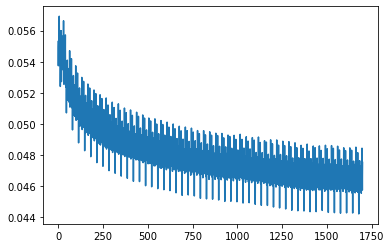

[0.05322408117353916, 0.05166581645607948, 0.05085971113294363, 0.05032300762832165, 0.050006396137177944, 0.04968135245144367, 0.049433243460953236, 0.049199423752725124, 0.049016572535037994, 0.04887363500893116, 0.048749279230833054, 0.04861627798527479, 0.04853521753102541, 0.04839871916919947, 0.048292817547917366, 0.04818574991077185, 0.04807171691209078, 0.04798813723027706, 0.04789734445512295, 0.04781479947268963, 0.047750500962138176, 0.04768136888742447, 0.04763493034988642, 0.04756572749465704, 0.04750829841941595, 0.04745572805404663, 0.047409831546247005, 0.04740064591169357, 0.047395145520567894, 0.04733130056411028, 0.04728612396866083, 0.04723535943776369, 0.04717875178903341, 0.047112248837947845, 0.04706237278878689, 0.04701658245176077, 0.04699122626334429, 0.04694850742816925, 0.04688083101063967, 0.046846043318510056, 0.046826739795506, 0.046826706267893314, 0.04681593831628561, 0.04680192843079567, 0.04680588096380234, 0.04681299813091755, 0.04678912088274956, 0.

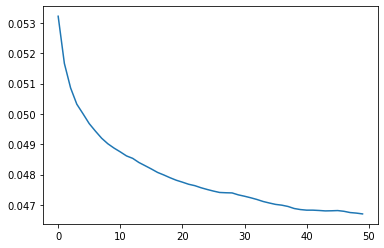

In [7]:
plt.plot(losses)
plt.show()

print(avg_val_losses)
plt.plot(avg_val_losses)
plt.show()

Keep track of how good the model did, compare file

In [8]:
from datetime import datetime
now = datetime.now()
lines = [now, model, model_loss,learning_rate,epochs,optimizer,losses[-100:], avg_val_losses ]
with open('All results.txt', 'a') as f:
    for line in lines:
        f.write(str(line))
        f.write('\n')
    f.write('\n')

iets van ROC curve of andere general methode om het model te testen

Use the model on the test data and get a score(normal_score/anomaly_score) to hopefully see a difference

In [11]:
def score(dataset, scoring_function):
    scores_normal = [] #scores of each waveform in the test dataset
    scores_abnormal = []
    
    
    for line_of_data in dataset.iloc():
        waveform = get_sample_waveform_normalised(line_of_data["Full Sample Name"], 4, 5)
        waveform_gpu = torch.FloatTensor(waveform).to(device=device)

        predicted_waveform = model(waveform_gpu)
        error = scoring_function(predicted_waveform,waveform_gpu)
        
        if line_of_data["norm/ab"] == "normal":
            scores_normal.append(error.detach().cpu().numpy().item()) 
        
        if line_of_data["norm/ab"] == "abnormal":
            scores_abnormal.append(error.detach().cpu().numpy().item()) 
   
    return scores_normal, scores_abnormal

scores_normal, scores_abnormal = score(test_dataset, scoring_function = nn.L1Loss())


<function matplotlib.pyplot.show(close=None, block=None)>

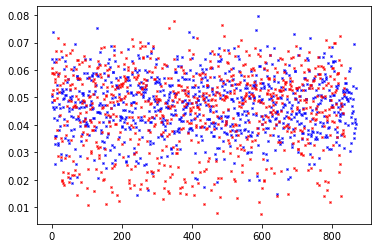

In [10]:
plt.plot(range(len(scores_normal)), scores_normal, 'bx',linewidth=1, markersize=2) 
plt.plot(range(len(scores_abnormal)), scores_abnormal, 'rx', linewidth=1, markersize=2 ) 
plt.show